## Welcome to the PSIG Short Course on Centrifugal Compressors and Stations

- This notebook accompanies the <a href="https://psig.org/conference/pipeline-simulation-short-course/">Pipeline Simulation Short Course</a>

- The source code is available at <a href="https://github.com/Cody-at-SolarTurbines/PSIG-Compressor-Course">Cody-at-SolarTurbines</a>

In [1]:
# standard python modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import solve, inv
import json

## Exercise 5

---

<font size="4">
Suppose the following data set is obtained from a test cell:
    
<br/>    

q = [3945, 2692, 4751, 6263, 5802] in ACFM 

p1 = [800, 801, 809, 806, 805] in psia
    
p2 = [676, 681, 680, 669, 671] in psia
    
T1 = [81, 81, 79, 80, 78, 80 ] in degF
    
Z1 = [0.966, 0.964, 0.963, 0.964, 0.965 ] unitless
    
SG = [0.555, 0.554, 0.556, 0.552, 0.555] unitless

Estimate 𝛼 using a <a href="https://mathworld.wolfram.com/LeastSquaresFitting.html">Least Squares</a> approach for equation: $Q = \alpha \sqrt{\frac{(p_1 - p_2) T_1 Z_1}{ p_1 SG}} $
</font>

---

## Solution 5:

<br/>

There are many ways to estimate $\alpha$.  We can do this numerically or calculate directly.  We do both below.

<br/><br/>

###  We will use Numpy and Scipy to implement the solution

These are python packages for scientific computing
- https://numpy.org/
- https://scipy.org/

### Import data

- Import the data and convert the data to Numpy arrays for computation

In [2]:
# Import data from a json file
with open('data.json', 'r') as openfile:
    data = json.load(openfile)
    
# convert data lists to numpy arrays
for k,v in data.items():
    data[k] = np.array(v)
    
    # t1 variable is in degF and we need degR
    if k == 't1':
        data[k] += 460

In [3]:
# create a DP variable
data['p_diff'] = data['p1']-data['p2']

# setup data in array
data_raw = np.vstack((data['p1'],data['p2'],data['t1'],
                      data['z1'],data['sg'],data['p_diff'],data['q']))

# sort by differential pressure (this will make for nice connected points on the plot)
data_sorted = data_raw[:,data_raw[5, :].argsort()]

# setup x_data and y_data
x_data = data_sorted[:5,:]
y_data = data_sorted[6,:]

#### What just happened above?

1) create a numpy array of the individual arrays

In [4]:
data_raw

array([[8.0000e+02, 8.0100e+02, 8.0900e+02, 8.0600e+02, 8.0500e+02],
       [7.9092e+02, 7.9677e+02, 7.9560e+02, 7.8273e+02, 7.8507e+02],
       [5.4100e+02, 5.4100e+02, 5.3900e+02, 5.4000e+02, 5.3800e+02],
       [9.6600e-01, 9.6400e-01, 9.6300e-01, 9.6400e-01, 9.6500e-01],
       [5.5000e-01, 5.4000e-01, 5.4000e-01, 5.3000e-01, 5.5000e-01],
       [9.0800e+00, 4.2300e+00, 1.3400e+01, 2.3270e+01, 1.9930e+01],
       [3.9450e+03, 2.6920e+03, 4.7510e+03, 6.2630e+03, 5.8020e+03]])

2) sort the entire array by the sort of the 6th row (corresponds to p_diff variable)

In [5]:
print('Here are the values:\t\t\t',data_raw[5, :])
print('Here is the index sort values\t\t',data_raw[5, :].argsort())

Here are the values:			 [ 9.08  4.23 13.4  23.27 19.93]
Here is the index sort values		 [1 0 2 4 3]


3)  Here is the sorted data array

In [6]:
data_sorted

array([[8.0100e+02, 8.0000e+02, 8.0900e+02, 8.0500e+02, 8.0600e+02],
       [7.9677e+02, 7.9092e+02, 7.9560e+02, 7.8507e+02, 7.8273e+02],
       [5.4100e+02, 5.4100e+02, 5.3900e+02, 5.3800e+02, 5.4000e+02],
       [9.6400e-01, 9.6600e-01, 9.6300e-01, 9.6500e-01, 9.6400e-01],
       [5.4000e-01, 5.5000e-01, 5.4000e-01, 5.5000e-01, 5.3000e-01],
       [4.2300e+00, 9.0800e+00, 1.3400e+01, 1.9930e+01, 2.3270e+01],
       [2.6920e+03, 3.9450e+03, 4.7510e+03, 5.8020e+03, 6.2630e+03]])

4) Down select for x_data only

In [7]:
x_data

array([[8.0100e+02, 8.0000e+02, 8.0900e+02, 8.0500e+02, 8.0600e+02],
       [7.9677e+02, 7.9092e+02, 7.9560e+02, 7.8507e+02, 7.8273e+02],
       [5.4100e+02, 5.4100e+02, 5.3900e+02, 5.3800e+02, 5.4000e+02],
       [9.6400e-01, 9.6600e-01, 9.6300e-01, 9.6500e-01, 9.6400e-01],
       [5.4000e-01, 5.5000e-01, 5.4000e-01, 5.5000e-01, 5.3000e-01]])

## Visualize the data

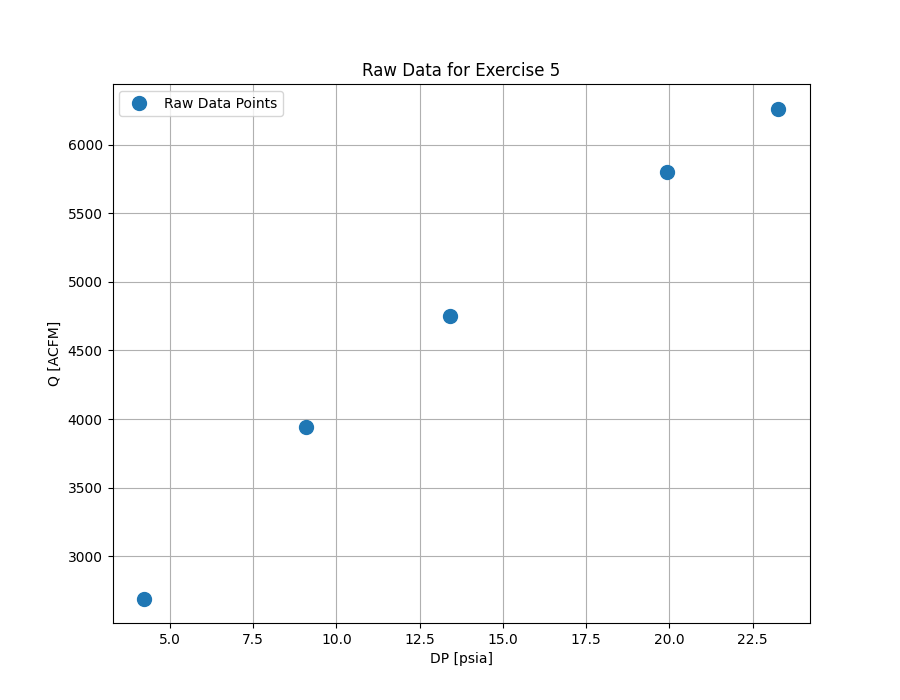

In [8]:
f, ax = plt.subplots(figsize=(9,7))
ax.plot(data_sorted[5,:], data_sorted[6,:], 'o', markersize=10, label='Raw Data Points')
ax.set_xlabel('DP [psia]')
ax.set_ylabel('Q [ACFM]')
ax.set_title('Raw Data for Exercise 5')
ax.grid()
ax.legend()

## Now create the flow function from the equation above

In [9]:
# create a function y = f(x_data,alpha)
# Note that x_data[0] = p1; x_data[1] = p2; and so on as above

def flow_q(x_data,alpha):
    """ Flow function from equation """
    return alpha*np.sqrt((x_data[0]-x_data[1])*x_data[2]*x_data[3]/(x_data[0]*x_data[4]))

### Use Scipy `curve_fit` method to find the optimal alpha value

- initial guess of 1000

In [10]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize._minpack_py:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``.
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, and each element should be float
        convertible if it is an array like object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial 

In [11]:
# popt = optimal coefficient
# pcov = covariance of popt

popt, pcov = curve_fit(flow_q,x_data,y_data,1000)
alpha = popt[0]
print(f'>>> The optimal alpha value is: {alpha}')

>>> The optimal alpha value is: 1189.8494326272464


### Now predict the flow, based on the optimal $\alpha$ and the given inputs

In [12]:
# we will call the estimated or predicted flow, yhat

yhat = flow_q(x_data,alpha) 

## Visualize the data and the fit

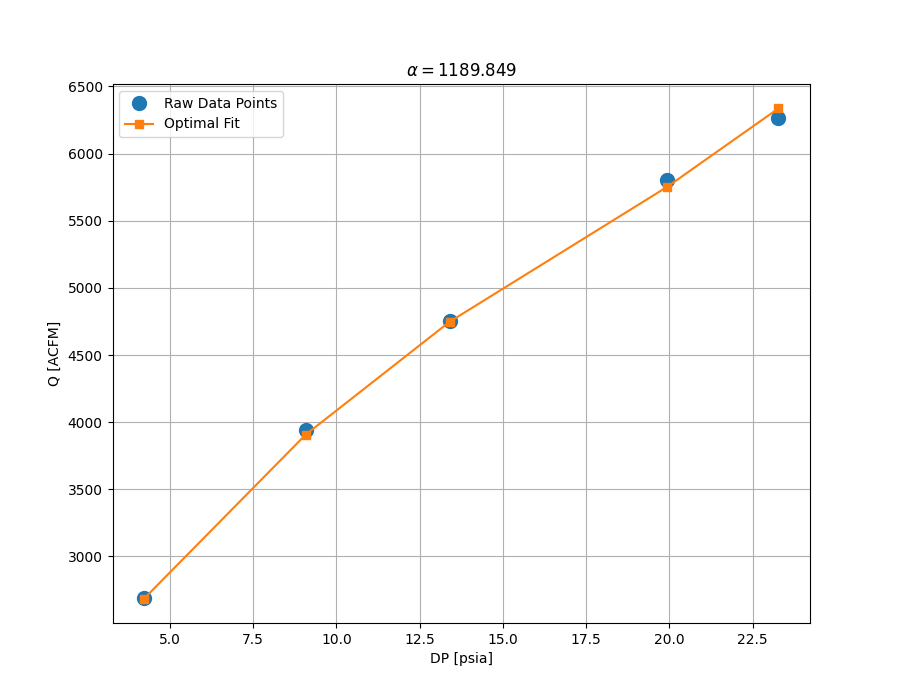

In [13]:
f, ax1 = plt.subplots(figsize=(9,7))
ax1.plot(data_sorted[5,:], data_sorted[6,:], 'o', markersize=10, label='Raw Data Points')
ax1.plot(data_sorted[5,:], yhat, '-s', label='Optimal Fit')
ax1.set_xlabel('DP [psia]')
ax1.set_ylabel('Q [ACFM]')
ax1.set_title('Raw Data for Exercise 5')
ax1.set_title(r'$\alpha = $' + f'{alpha:.3f}')
ax1.grid()
ax1.legend()

### If we need $\beta$, we can solve for it since $\alpha = \sqrt{1/\beta} \Leftrightarrow \beta = 1/\alpha^2$

In [14]:
beta = 1/alpha**2
print(f'Beta = {beta:.10f}')

Beta = 0.0000007063


## Solution 5 (Bonus)

$\alpha$ can be calculated directly with <a href="https://mathworld.wolfram.com/LeastSquaresFitting.html">sums</a> or <a href="https://www.khanacademy.org/math/linear-algebra/alternate-bases/orthogonal-projections/v/linear-algebra-least-squares-examples">linear algebra</a>, instead of using a numerical solver like the Levenberg-Marquardt, which is the default in `curve_fit`.

We will use linear algebra.  We want to put the data in the form $Ax = b$ and solve for $x$.  Note that the equation is of the form $Q_i=\alpha K_i$, where $i$ is the $i$th observation and $K_i$ is constant in the input parameters!

Therefore, we can simply solve the <a href="https://mathworld.wolfram.com/NormalEquation.html">Normal Equation</a>: $x^* = (A^TA)^{-1}A^Tb = \alpha$

All that we need to do is create the matrix $A$ (which is 1-dimensional in this case)

In [15]:
# setup matrix A

A = np.array([flow_q(x_observation,1) for x_observation in x_data.T]).reshape((5,1))

In [16]:
# solve the normal equation

alpha_normal = np.dot(np.dot(inv(np.dot(A.T,A)),A.T),y_data)

print(f'Normal Equation alpha:\t\t\t {alpha_normal[0]}')
print(f'Numerically solved for alpha:\t\t {alpha}')

Normal Equation alpha:			 1189.849432605296
Numerically solved for alpha:		 1189.8494326272464
